# Feedforward Neural Network with PyTorch on [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset
By [Zahra Taheri](https://github.com/zahta), October 12, 2020

### Preperation for Google colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#unzip dataset files from google drive to content folder in colab

import os

if os.path.exists("/content/cifar-10-batches-py/")==False:
  print("unzip files!")
  !unzip -q "/content/drive/My Drive/cifar-10-batches-py.zip"

mypath="/content/cifar-10-batches-py/"

In [3]:
#Define path to the directory
 
os.chdir(mypath)

print(os.getcwd())

/content/cifar-10-batches-py


### Import libraries

In [4]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('axes', labelsize=10)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)

import os

np.random.seed(100)

## Loading CIFAR-10

In [5]:
%run load_cifar10.py

In [6]:
#Define path to the directory
 
os.chdir("/content/")

print(os.getcwd())

/content


In [7]:
cifar_10_dir = 'cifar-10-batches-py'
train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = \
load_cifar_10_data(cifar_10_dir)
print("Train data: ", train_data.shape)
print("Train filenames: ", train_filenames.shape)
print("Train labels: ", train_labels.shape)
print("Test data: ", test_data.shape)
print("Test filenames: ", test_filenames.shape)
print("Test labels: ", test_labels.shape)
print("Label names: ", label_names.shape)

Train data:  (50000, 32, 32, 3)
Train filenames:  (50000,)
Train labels:  (50000,)
Test data:  (10000, 32, 32, 3)
Test filenames:  (10000,)
Test labels:  (10000,)
Label names:  (10,)


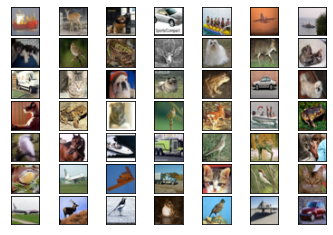

In [8]:
# display some random training images
num_plot = 7
f, ax = plt.subplots(num_plot, num_plot)
for m in range(num_plot):
    for n in range(num_plot):
        idx = np.random.randint(0, train_data.shape[0])
        ax[m, n].imshow(train_data[idx])
        ax[m, n].get_xaxis().set_visible(False)
        ax[m, n].get_yaxis().set_visible(False)
f.subplots_adjust(hspace=0.1)
f.subplots_adjust(wspace=0)
plt.show()

## Preparation of the dataset

In [9]:
#nsamples1, a1,b1,c1 = train_data.shape
#X_train= train_data.reshape((nsamples1,a1*b1*c1))
#nsamples2, a2,b2,c2 = test_data.shape
#X_test= test_data.reshape((nsamples2,a2*b2*c2))

# Data standardization
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test= scaler.transform(X_test)

#train_data = X_train.reshape((nsamples1, a1,b1,c1))
#test_data= X_test.reshape((nsamples2, a2,b2,c2))

In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader

tensor_x = torch.Tensor(train_data) # transform to torch tensor
tensor_y = torch.Tensor(train_labels)
tensor_y = tensor_y.type(torch.LongTensor)

train_dataset = TensorDataset(tensor_x,tensor_y) # create your dataset

In [11]:
tensor_x2 = torch.Tensor(test_data)
tensor_y2 = torch.Tensor(test_labels)
tensor_y2 = tensor_y2.type(torch.LongTensor)

test_dataset = TensorDataset(tensor_x2,tensor_y2)

In [12]:
tensor_y

tensor([6, 9, 9,  ..., 9, 1, 1])

## Building Feedforward Neural Networks with PyTorch

In [13]:
# import libraries
import torch
import torch.nn as nn

from torch.autograd import Variable
from torchsummary import summary

### Model A: 1 hidden layer (ReLU activation)

#### Make dataset iterable

In [14]:
batch_size = 128
n_iters = 5000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

12


In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

### Create model class

In [16]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # non-linearity
        self.relu = nn.ReLU()
        # linear function
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # linear function
        out = self.fc1(x)
        # non-linearity
        out = self.relu(out)
        #linear function
        out = self.fc2(out)
        return out       
    

In [17]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 10
hidden_dim = 700

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [18]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 700]       2,151,100
              ReLU-2               [-1, 1, 700]               0
            Linear-3                [-1, 1, 10]           7,010
Total params: 2,158,110
Trainable params: 2,158,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 8.23
Estimated Total Size (MB): 8.26
----------------------------------------------------------------


In [19]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [20]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 3*32*32).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, 3*32*32))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        
        '''
        Save loss to draw loss curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 3*32*32).cuda())
                else:
                    images = Variable(images.view(-1, 3*32*32))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 2.252075672149658. Accuracy: 12
Iteration: 1000. Loss: 2.0555834770202637. Accuracy: 19
Iteration: 1500. Loss: 2.0656378269195557. Accuracy: 20
Iteration: 2000. Loss: 2.065124273300171. Accuracy: 26
Iteration: 2500. Loss: 1.9436589479446411. Accuracy: 31
Iteration: 3000. Loss: 1.9792686700820923. Accuracy: 34
Iteration: 3500. Loss: 2.1866438388824463. Accuracy: 23
Iteration: 4000. Loss: 1.9026165008544922. Accuracy: 30
Iteration: 4500. Loss: 1.9030134677886963. Accuracy: 31


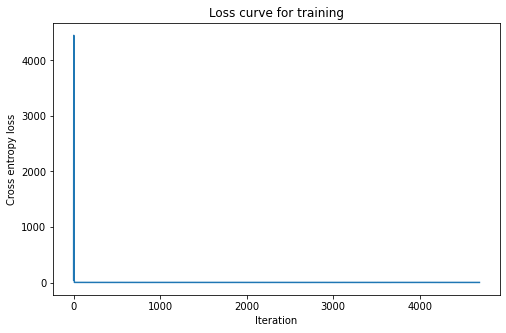

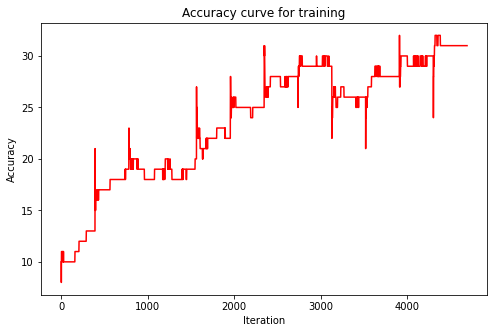

In [21]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [22]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), 'feedforward_neural_network_pytorch_A.pkl')# only save parameters

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU Activation)

#### Make dataset iterable

In [23]:
batch_size = 128
n_iters = 5000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

12


In [24]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [25]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [26]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 10
hidden_dim = 700 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [27]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 700]       2,151,100
              ReLU-2               [-1, 1, 700]               0
            Linear-3               [-1, 1, 700]         490,700
              ReLU-4               [-1, 1, 700]               0
            Linear-5               [-1, 1, 700]         490,700
              ReLU-6               [-1, 1, 700]               0
            Linear-7                [-1, 1, 10]           7,010
Total params: 3,139,510
Trainable params: 3,139,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 11.98
Estimated Total Size (MB): 12.02
----------------------------------------------------------------


In [28]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [29]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 3*32*32).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, 3*32*32))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        
        '''
        Save loss to draw loss curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 3*32*32).cuda())
                else:
                    images = Variable(images.view(-1, 3*32*32))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 1.6838189363479614. Accuracy: 39
Iteration: 1000. Loss: 1.5056724548339844. Accuracy: 42
Iteration: 1500. Loss: 1.4506161212921143. Accuracy: 43
Iteration: 2000. Loss: 1.4965437650680542. Accuracy: 42
Iteration: 2500. Loss: 1.4233163595199585. Accuracy: 45
Iteration: 3000. Loss: 1.4530705213546753. Accuracy: 45
Iteration: 3500. Loss: 1.473315715789795. Accuracy: 46
Iteration: 4000. Loss: 1.4307129383087158. Accuracy: 47
Iteration: 4500. Loss: 1.3141430616378784. Accuracy: 48


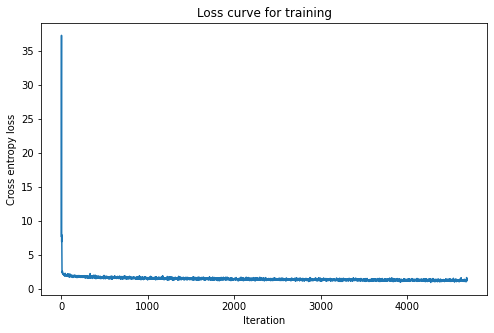

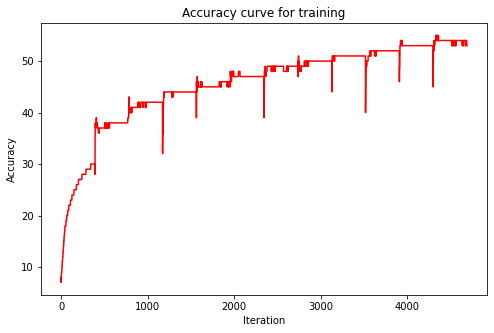

In [30]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [31]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), 'feedforward_neural_network_pytorch_B.pkl')# only save parameters

### Model C: 3 Hidden Layers Feedforward Neural Network (ReLU and LeakyReLU Activation functions)

#### Make dataset iterable

In [32]:
batch_size = 128
n_iters = 8000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [33]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [34]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # non-linearity 1
        self.relu1 = nn.LeakyReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.LeakyReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [35]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 10
hidden_dim1 = 700
hidden_dim2 = 1200
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [36]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 700]       2,151,100
         LeakyReLU-2               [-1, 1, 700]               0
            Linear-3              [-1, 1, 1200]         841,200
         LeakyReLU-4              [-1, 1, 1200]               0
            Linear-5               [-1, 1, 512]         614,912
              ReLU-6               [-1, 1, 512]               0
            Linear-7                [-1, 1, 10]           5,130
Total params: 3,612,342
Trainable params: 3,612,342
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 13.78
Estimated Total Size (MB): 13.83
----------------------------------------------------------------


In [37]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [38]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 3*32*32).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, 3*32*32))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        
        '''
        Save loss to draw loss curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 3*32*32).cuda())
                else:
                    images = Variable(images.view(-1, 3*32*32))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 1.553972840309143. Accuracy: 38
Iteration: 1000. Loss: 1.9162052869796753. Accuracy: 41
Iteration: 1500. Loss: 1.3922277688980103. Accuracy: 43
Iteration: 2000. Loss: 1.4621089696884155. Accuracy: 44
Iteration: 2500. Loss: 1.4110852479934692. Accuracy: 46
Iteration: 3000. Loss: 1.363836646080017. Accuracy: 45
Iteration: 3500. Loss: 1.3495701551437378. Accuracy: 46
Iteration: 4000. Loss: 1.2374250888824463. Accuracy: 47
Iteration: 4500. Loss: 1.396457314491272. Accuracy: 49
Iteration: 5000. Loss: 1.0986289978027344. Accuracy: 48
Iteration: 5500. Loss: 1.113112211227417. Accuracy: 49
Iteration: 6000. Loss: 1.0931828022003174. Accuracy: 49
Iteration: 6500. Loss: 1.2374920845031738. Accuracy: 49
Iteration: 7000. Loss: 0.96852707862854. Accuracy: 50
Iteration: 7500. Loss: 1.002843976020813. Accuracy: 49


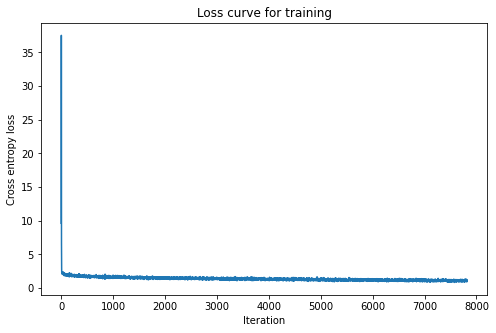

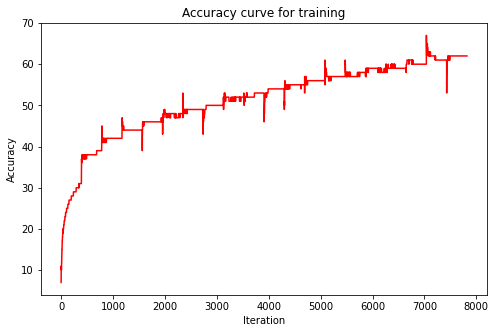

In [39]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [40]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), 'feedforward_neural_network_pytorch_C.pkl')# only save parameters

### Model D: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [41]:
batch_size = 128
n_iters = 8000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [42]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [43]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # non-linearity 1
        self.relu1 = nn.LeakyReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.LeakyReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        # non-linearity 3
        self.relu3 = nn.LeakyReLU()
        
        # linear function 4 (readout) 
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [44]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 10
hidden_dim1 = 1530
hidden_dim2 = 768
hidden_dim3 = 384 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [45]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1530]       4,701,690
         LeakyReLU-2              [-1, 1, 1530]               0
            Linear-3               [-1, 1, 768]       1,175,808
         LeakyReLU-4               [-1, 1, 768]               0
            Linear-5               [-1, 1, 384]         295,296
         LeakyReLU-6               [-1, 1, 384]               0
            Linear-7                [-1, 1, 10]           3,850
Total params: 6,176,644
Trainable params: 6,176,644
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 23.56
Estimated Total Size (MB): 23.61
----------------------------------------------------------------


In [46]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [47]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 3*32*32).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, 3*32*32))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        
        '''
        Save loss to draw loss curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 3*32*32).cuda())
                else:
                    images = Variable(images.view(-1, 3*32*32))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 1.6577132940292358. Accuracy: 40
Iteration: 1000. Loss: 1.575039029121399. Accuracy: 42
Iteration: 1500. Loss: 1.6061145067214966. Accuracy: 44
Iteration: 2000. Loss: 1.5516225099563599. Accuracy: 43
Iteration: 2500. Loss: 1.5533044338226318. Accuracy: 44
Iteration: 3000. Loss: 1.2006382942199707. Accuracy: 47
Iteration: 3500. Loss: 1.3286184072494507. Accuracy: 45
Iteration: 4000. Loss: 1.1812423467636108. Accuracy: 48
Iteration: 4500. Loss: 1.321233868598938. Accuracy: 48
Iteration: 5000. Loss: 1.3425030708312988. Accuracy: 47
Iteration: 5500. Loss: 1.3101441860198975. Accuracy: 49
Iteration: 6000. Loss: 1.0564908981323242. Accuracy: 50
Iteration: 6500. Loss: 1.0794072151184082. Accuracy: 50
Iteration: 7000. Loss: 0.9521958231925964. Accuracy: 49
Iteration: 7500. Loss: 0.977176308631897. Accuracy: 50


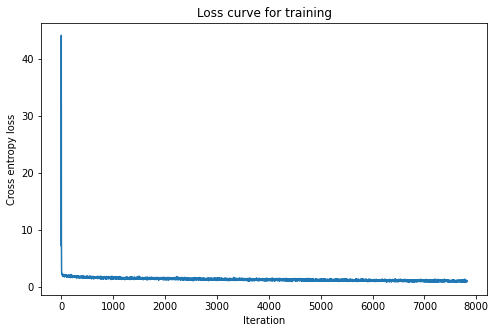

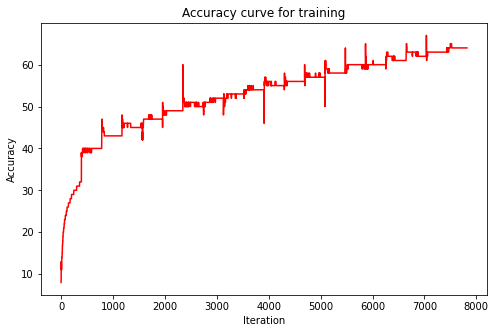

In [48]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [49]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), 'feedforward_neural_network_pytorch_D.pkl')# only save parameters

### Model E: 5 Hidden Layers Feedforward Neural Network (ReLU Activation)

#### Make dataset iterable

In [14]:
batch_size = 128
n_iters = 8000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [16]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,hidden_size4,hidden_size5, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # non-linearity 1
        self.relu1 = nn.LeakyReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
        # non-linearity 4
        self.relu4 = nn.ReLU()
        
        # linear function 5
        self.fc5 = nn.Linear(hidden_dim4, hidden_dim5)
        # non-linearity 5
        self.relu5 = nn.ReLU()
        
        # linear function 6 (readout)
        self.fc6 = nn.Linear(hidden_dim5, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        # linear function 4
        out = self.fc4(out)
        # non-linearity 4
        out = self.relu4(out)
        
        # linear function 5
        out = self.fc5(out)
        # non-linearity 5
        out = self.relu5(out)
        
        #linear function 6 (readout)
        out = self.fc6(out)
        return out       
    

In [17]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 10
hidden_dim1 = 1530
hidden_dim2 = 770
hidden_dim3 = 380
hidden_dim4 = 15
hidden_dim5 = 10
model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [18]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1530]       4,701,690
         LeakyReLU-2              [-1, 1, 1530]               0
            Linear-3               [-1, 1, 770]       1,178,870
              ReLU-4               [-1, 1, 770]               0
            Linear-5               [-1, 1, 380]         292,980
              ReLU-6               [-1, 1, 380]               0
            Linear-7                [-1, 1, 15]           5,715
              ReLU-8                [-1, 1, 15]               0
            Linear-9                [-1, 1, 10]             160
             ReLU-10                [-1, 1, 10]               0
           Linear-11                [-1, 1, 10]             110
Total params: 6,179,525
Trainable params: 6,179,525
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw

In [19]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [20]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 3*32*32).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, 3*32*32))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        
        '''
        Save loss to draw loss curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 3*32*32).cuda())
                else:
                    images = Variable(images.view(-1, 3*32*32))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 2.190581798553467. Accuracy: 23
Iteration: 1000. Loss: 1.9961891174316406. Accuracy: 29
Iteration: 1500. Loss: 1.9107896089553833. Accuracy: 32
Iteration: 2000. Loss: 1.8793220520019531. Accuracy: 35
Iteration: 2500. Loss: 1.6317336559295654. Accuracy: 39
Iteration: 3000. Loss: 1.475569725036621. Accuracy: 40
Iteration: 3500. Loss: 1.691741943359375. Accuracy: 40
Iteration: 4000. Loss: 1.5256859064102173. Accuracy: 41
Iteration: 4500. Loss: 1.721673607826233. Accuracy: 41
Iteration: 5000. Loss: 1.5089995861053467. Accuracy: 44
Iteration: 5500. Loss: 1.550392508506775. Accuracy: 45
Iteration: 6000. Loss: 1.4892139434814453. Accuracy: 46
Iteration: 6500. Loss: 1.358691930770874. Accuracy: 46
Iteration: 7000. Loss: 1.3801418542861938. Accuracy: 48
Iteration: 7500. Loss: 1.201481819152832. Accuracy: 47


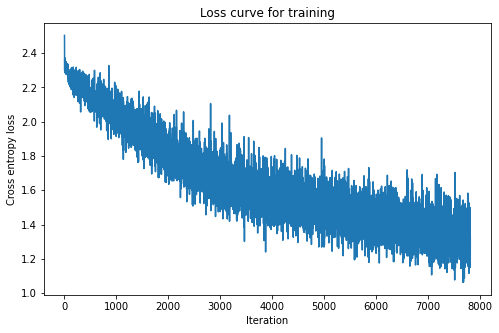

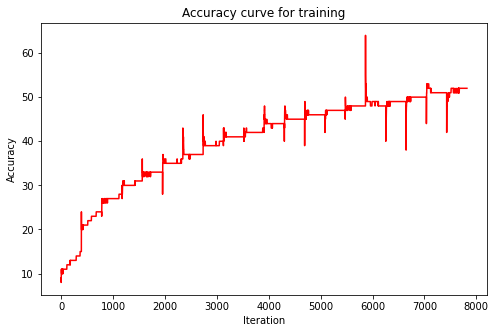

In [21]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [22]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), 'feedforward_neural_network_pytorch_E.pkl')# only save parameters